<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Class - Week 6

## Department of Mathematics

# This Week

- Demo 6.1 Stochastic Volatility
- Demo 6.2 Path Dependent Options

# Demo 6.1: Stochastic Volatility

A popular model for option pricing is the Heston model, named after its academic creator. As motivation for this model, it is often stated that &ldquo;volatility (or variance of stock prices) is stochastic&ldquo;, and the starting point is to write down a multifactor model for stock prices. However the main reason for the popularity of the model is that it has analytic solutions (for the probability density function) and provides a better match to market prices than other competing models. It does not necessarily provide a better model of stock prices than the standard geometric Brownian motion.

Let us now describe the model itself. Under the risk nuetral measure, a stock paying dividends at the continuous rate $q$ moves according to the following SDEs:
$$
\begin{align}
    dS   & = (r-q) S dt + \sqrt{\nu} S dW_1 \\
    d\nu & = \kappa(\theta - \nu) dt + \xi \sqrt{\nu} dW_2
\end{align}
$$
where $W_1$ and $W_2$ are correlated Weiner processes with linear correlation parameter $\rho$. The parameters $\kappa$, $\theta$ and $\xi$ are risk adjusted positive constants, and $r$ is the risk-free rate.

Unfortunately this model does not have an analytic solution in the risk neutral measure, so we will need to simulate the entire path to get option prices.
First, we consider that time is split into $K$ equally spaced periods of time, such that
$$
\Delta t = \frac{T}{K} ,\quad \text{ and }\quad t^k = k\Delta t.
$$


Then we can create a random paths using an Euler-Maruyama scheme on both SDEs
$$S^{k+1} = S^{k}+(r-q)S^{k}\Delta t + \sqrt{\nu^k}S^{k} \Delta W_1$$ 
$$\nu^{k+1} = \nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2$$ 
To generate a pair $(\Delta W_1,\Delta W_2)$ of normally distributed, linear correlated random numbers, we use
$$
\begin{align}
    \Delta W_1 & = \sqrt{\Delta t}\, \phi_1 \\
    \Delta W_2 & = \sqrt{\Delta t}\, \rho\phi_1 + \sqrt{\Delta t}\sqrt{(1-\rho^2)}\, \phi_2 
\end{align}
$$
where $\phi_1\sim N(0,1)$ and $\phi_2\sim N(0,1)$ are independent uncorrelated draws from the standard normal distribution. Note that in python you can also sample directly from the multivariate normal to get $(\Delta W_1,\Delta W_2)$.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import fabs, exp, sqrt
from scipy.stats import norm

prng = np.random.default_rng(seed=8675309)

Now create some parameters for our problem. 

In [26]:
# stock parameters
S_0 = 98.31 # initial stock price
q = 0.01 # dividend yield

# call option contract parameters
X = 100 # strike price
T = 1.0 # time to expiry

# market parameters
r = 0.03 # risk free interest rate

# model parameters
kappa_nu = 1.5 # mean reversion parameter
theta_nu = 0.06 # long term value of the variance
nu_0 = 0.04 # initial variance
xi_nu = 0.4 # so called volatility of volatility
rho = -0.5 # correlation

For the numerical problem, we start with a relatively small number of paths to keep the computations quick.

In [27]:
N = 1000 # Number of paths
K = 200 # Steps per path

First generate numbers from standard normals, in this case we create an $N\times K$ matrix of $\phi$ values, to store the $K$ random numbers for each of the $N$ paths.

In [30]:
dt = T/K # timestep

# Construct correlated Wiener process steps.
# Begin by sampling two sets of i.i.d. standard normals
phi1 = prng.normal( 0.0 , 1.0 , size = (N,K) )
phi2 = prng.normal( 0.0 , 1.0 , size = (N,K) )

# Form suitably weighted linear combinations of the phis
# so as to get corelated variables
dW1 = np.zeros((N,K))
dW2 = np.zeros((N,K))

sqrt_dt = np.sqrt(dt)
dW1 = sqrt_dt*phi1
dW2 = rho*sqrt_dt*phi1 + sqrt_dt*np.sqrt(1-rho*rho)*phi2

Now look at some of the pairs $(\Delta W_1,\Delta W_2)$. If the $\rho>0$, we should see the results cluster along the line $y=x$, whereas if $\rho<0$ they should cluster along $y=-x$.

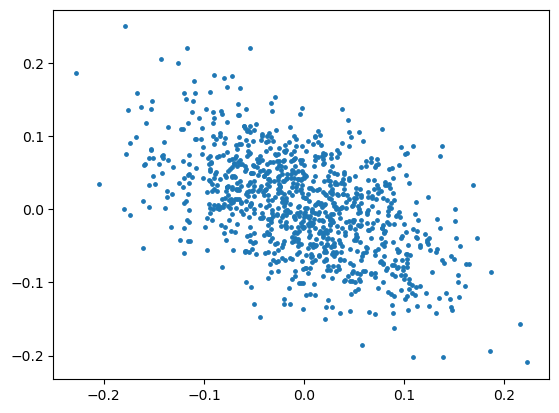

In [31]:
plt.scatter( dW1.T[0], dW2.T[0], s=6 )

Next, sample directly from the multivariate normal. This requires us to specify a mean and a covariance matrix. For the $dW_i$, we use the means 
$$
E[dW_1] = 0 , \quad\text{ and } \quad E[dW_2]=0
$$
and covariance
$$
\text{Cov}(dW_1,dW_2) = \left( \begin{array}{cc} 
dt & \rho dt\\ 
\rho dt &  dt 
\end{array}
\right) .
$$

Note that in the call to the multivariate normal generator, we use the transpose `(:::).T` to get the results into the variables `dW1` and `dW2`. As a result, we reverse the size call `size=(K,N)` to get the matrix in the correct format.

In [32]:
dW1 , dW2 = prng.multivariate_normal( [ 0.0 , 0.0 ] , [ [ dt , rho*dt ] , [ rho*dt , dt] ] , size = (K,N) ).T

You should notice that the call to this function is significantly quicker than the other one, even though the results look the same if we plot them out.

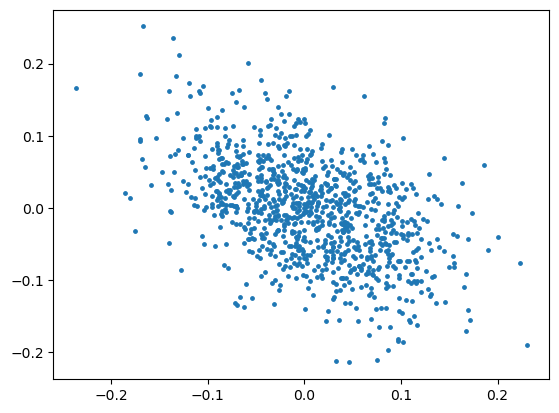

In [33]:
plt.scatter( dW1.T[0], dW2.T[0], s=6 )

Next let us construct a single path and see what it looks like.

Text(0.5, 0, '$t$')

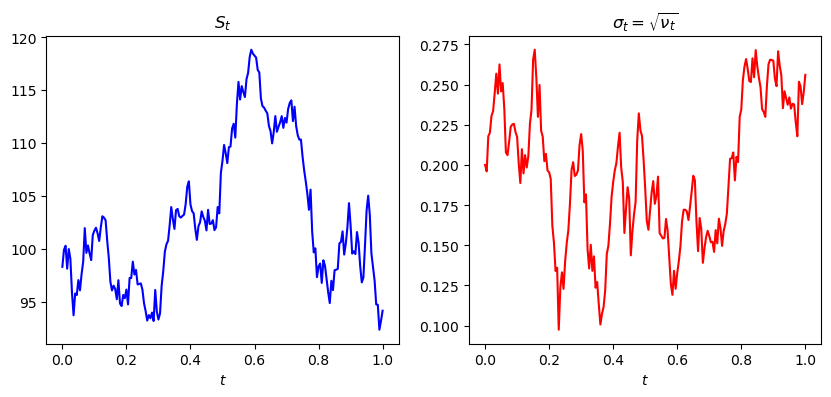

In [8]:
# Prepare storage for the paths in S and nu.
# Note that as we have an initial value and then take K steps,
# we'll need arrays of length (K+1) to hold the lists of sampling
# times and SDE values.
time = np.zeros(K+1)
S_t = np.zeros(K+1)
nu_t = np.zeros(K+1)

# Initialise the paths with their first values
S_t[0] = S_0
nu_t[0] = nu_0

# Now extend the path in the Euler-Maruyama way
i=0 # path number
for k in range(K):
    nu_sqrt=np.sqrt(nu_t[k])
    time[k+1] = (k+1)*dt
    S_t[k+1] = S_t[k] + (r-q)*S_t[k]*dt + nu_sqrt*S_t[k]*dW1[i][k]
    nu_t[k+1] = nu_t[k] + kappa_nu*(theta_nu - nu_t[k])*dt + xi_nu*nu_sqrt*dW2[i][k]
    
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(time, S_t, color='blue')
plt.title('$S_t$')
plt.xlabel( '$t$' )

plt.subplot(1, 2, 2)
plt.plot(time, np.sqrt(nu_t), color='red')
plt.title('$\\sigma_t = \\sqrt{\\nu_t}$')
plt.xlabel( '$t$' )

The results look reasonable, we can see the negative correlation in effect (stock goes up volatility goes down), and the stock has higher variance when $\sigma_t$ is higher. However there is one worrying feature, $\nu_t$ is getting very close to zero...

# Tasks

- Run the code for path $i=1,2,...$ and plot them on the graph &mdash; do you encounter any problems?
- If $\nu_t<0$ is causing problems, add a *reflecting boundary* to your path calculation, that is
$$\nu^{k+1} =\left\{ \begin{array}{cc}
\nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2 &\text{ if } \quad \nu^k + d\nu^k \geq 0\\
-(\nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2) &\text{ if }\quad \nu^k + d\nu^k < 0
\end{array}\right.
$$  
- Simulate $N$ paths and calculate the average payoff of a call option to estimate the call option value
- Analyse the results for different values of $N$ and $K$, what can you say about the effect of increasing or decreasing each of the numerical parameters.

For the model parameters: $S_0 = 98.31$, $q = 0.01$, $X = 100$, $T = 1$, $r=0.03$, $\kappa = 1.5$, $\theta = 0.06$, $\nu_0 = 0.04$, $\xi = 0.4$ and $\rho = -0.5 $ the analytic result found using a numerical library is $C(S_0,t=0)=8.2623461$.
- What can you say about the errors of your Monte Carlo *vs.* this value?

# Demo 6.2: Path Dependent Options

Assume that the stock price $S_t$ is observed at $K+1$ equally-spaced time points $t_0,t_1,\dots,t_K$ with $t_0=0$ and $t_K=T$. Now let us find the value of a path dependent option where
we define the underlying asset $A$ to be the average absolute movements in the share price over several periods such that
$$
A = \frac{\sum_{i=1}^K | S(t_i) - S(t_{i-1}) |}{\sqrt{K}} .
$$
Assuming the Black-Scholes framework under the risk-neutral measure, and we wish to price a call option with payoff 
$$
C(A,S,t=T)=\max(A-X,0).
$$ 

Find the value
$$
C(S_0,t=0) = e^{-rT} \mathbb{E}^Q[\max(A-X,0)]
$$
- where $K=20$, strike price $X=30$ and a maturity $T=1$ is one year from now;
- the current stock price is $S_0=104.81$;
- the stock price follows a GBM with $\sigma=0.4$, the interest rate is $r=0.03$.
 

First start by adding some parameters from the question and setting up your random number generator. 

In [9]:
import matplotlib.pyplot as plt
import numpy

prng = np.random.default_rng(seed=8675309)
S_0 = 104.82
sigma=0.4
r=0.03
T=1.
X=30.

K=20
N=1000

Now create a path and check it looks reasonable.

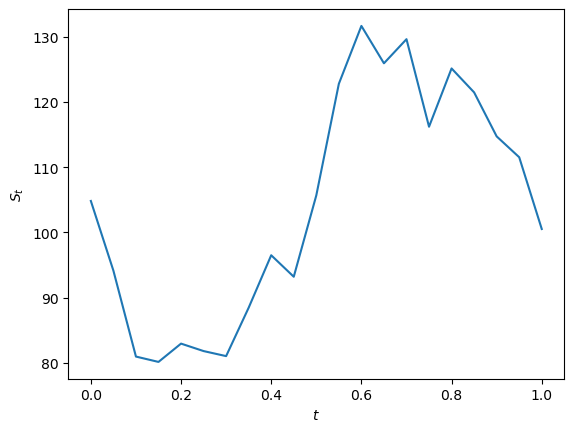

In [12]:
dt = T/K # Time step
dW = prng.normal( 0.0 , np.sqrt(dt) , size = K ) # Wiener process: one value for each step 

# Construct the path using an Euler-Maruyama scheme
S_t = np.zeros(K+1)

S_t[0] = S_0
for k in range(K):
    S_t[k+1] = S_t[k] * np.exp((r-0.5*sigma*sigma)*dt+sigma*dW[k])

# Plot that puppy
tVals = np.array( [j*dt for j in range(K+1)] )
plt.plot(tVals, S_t)
plt.xlabel( "$t$" )
plt.ylabel( "$S_t$" )
plt.ylabel( "$S_t$" )

plt.show()

Next calculate the value of $A$ from this first path, does it look reasonable?

In [13]:
A=0.0
for k in range(0,K):
    A = A + fabs(S_t[k+1] - S_t[k])
A = A/np.sqrt(K)
print("A:=",A)

A:= 32.01622925527915


Now put this together, run $N$ paths, and take the average of the payoff.


In [14]:
# Generate all Wiener process values - one per step per path -
# at a stroke. We'll store them in a matrix whose rows correspond to paths.
dW = prng.normal( 0.0 , np.sqrt(dt) , size = (N, K) )

# We won't store all the paths, just construct them one at a time,
# compute A and the associated payoff, and then discard
# the path.
S_t = np.zeros(K+1) # Storage for a single path
payoff = np.zeros(N) # One per path

# Construct N paths, one at a time, and record the
# associated valules of A.
for i in range(N):
    # Initialise asset and path variables
    S_t[0] = S_0
    A_numerator_sum = 0.0
    
    # Construct the path with Euler-Maruyama steps, accumulating
    # the numerator of A as we go.
    for k in range(K):
        S_t[k+1] = S_t[k] * np.exp((r-0.5*sigma*sigma)*dt+sigma*dW[i][k])
        A_numerator_sum += fabs(S_t[k+1] - S_t[k])

    # Compute and store A
    A = A_numerator_sum / np.sqrt(K)
    
    # Now compute and record the payoff
    payoff[i] = max(A-X,0.0)

print( payoff[0:5] )
discountedExpectedPayoff = exp(-r*T) * np.mean(payoff)
print( f"C = {discountedExpectedPayoff}" )

[0.         0.         0.         0.         7.51237747]
C = 6.613092617345927


# Tasks

- Package your solution as a function
- Analyse the effect of $N$ and $K$ on your results
- There is no obvious analytic solution for the discrete case $K=20$ &mdash; are you able to estimate the error even if you don't know the real solution? 
- Choosing the largest value of $N$ you can feasibly run given the available time, state a confidence interval for the result.

In [15]:
# Try to accelerate the code
from numba import njit

# Define a function to generate N paths, each of K steps, 
# and return the associated payoffs.

@njit
def estimateOptionVal( K, N, S_0, r, sigma, T, X, rng ):
    # Compute the time step
    dt = T / K
    
    # Generate all Wiener process values - one per each step in each path -
    # at a stroke. We'll store them in a matrix whose rows correspond to paths.
    dW = rng.normal( 0.0 , np.sqrt(dt) , size = (N, K) )
    
    # Store the paths in a matrix, one path per row
    S_t = np.zeros( (N, K+1) ) 
    A_numerator_sum = np.zeros(N) # scrtach space
    payoff = np.zeros(N)
    
    # Construct the paths with Euler-Maruyama steps, accumulating
    # the numerator of A as we go. Here we work with whole columns
    # in a single step
    S_t[:,0] = S_0
    for k in range(K):
        # Extend all N paths from t_k to t_{k+1}
        
        S_t[:,k+1] = S_t[:,k] * np.exp((r-0.5*sigma*sigma)*dt+sigma*dW[:,k])

        # Accumulate the numerators of the A's
        A_numerator_sum += np.fabs(S_t[:,k+1] - S_t[:,k])
    
    # Compute and store A
    A = A_numerator_sum / sqrt(K)
        
    # Now compute the payoff and return its discounted version
    payoff = np.maximum(A-X, 0.0)
    return exp( -r*T) * payoff

In [16]:
# Try an example
K = 20
N = 10
estimateOptionVal( K, N, S_0, r, sigma, T, X, prng )

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       27.51595107, 31.29858453,  8.80211026, 14.00682567,  0.        ])

In [17]:
# Choose a range of sample sizes
nSizes = 7 
sampleSize = [1000*int(pow(2,j+1)) for j in range(nSizes)]
sampleSize

[2000, 4000, 8000, 16000, 32000, 64000, 128000]

In [18]:
# Focus on the case we're asked about
K = 20

# Assemble lots of reps at each sample size
repsPerSize=100
results = np.zeros((nSizes, repsPerSize))
for j in range(nSizes):
    N = sampleSize[j]
    for k in range(repsPerSize):
        discountedPayoffs = estimateOptionVal( K, N, S_0, r, sigma, T, X, prng )
        results[j,k] = np.mean( discountedPayoffs )

In [17]:
import pandas as pd

# Consruct 95% confidence intervals
mean_vs_N = np.mean( results, axis=1 ) # does means across rows
sd_vs_N = np.std( results, axis=1 ) # does std deviations across rows

conf = 0.95
alpha = 1.0 - conf
std_CI_halfWidth = norm.ppf(1.0 - 0.5*alpha) 

CI_lb = mean_vs_N - std_CI_halfWidth*sd_vs_N
CI_ub = mean_vs_N + std_CI_halfWidth*sd_vs_N

# Assemble the results into a nice table and display them
result_df = pd.DataFrame( {
    "$N$": sampleSize, 
    "Mean $V(t=0)$":mean_vs_N,
    "SD $V(t=0)$": sd_vs_N,
    "CI lower bound": CI_lb,
    "CI upper bound": CI_ub
})

print( result_df )

      $N$  Mean $V(t=0)$  SD $V(t=0)$  CI lower bound  CI upper bound
0    2000       5.740568     0.201264        5.346099        6.135038
1    4000       5.736236     0.129201        5.483006        5.989465
2    8000       5.736387     0.092068        5.555936        5.916837
3   16000       5.736513     0.065328        5.608472        5.864553
4   32000       5.747524     0.049452        5.650601        5.844448
5   64000       5.752362     0.031523        5.690578        5.814145
6  128000       5.743340     0.022464        5.699312        5.787368


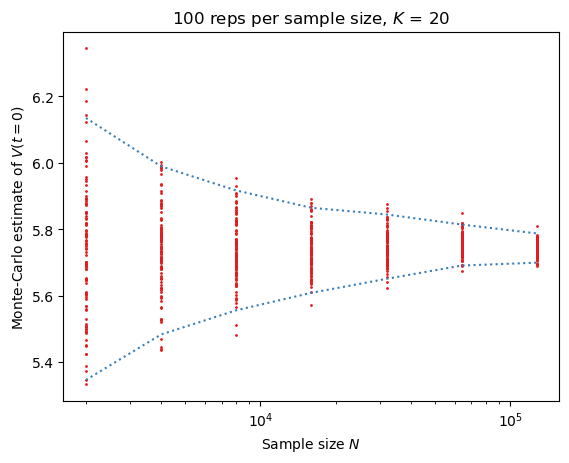

In [18]:
# Choose some pleasing colors from the Brewer palettes
cmap = plt.colormaps["Set1"]
set_pal = cmap(range(0,9))

for j in range(nSizes):
    plt.semilogx( np.repeat(sampleSize[j], repsPerSize), results[j,:], color=set_pal[0], marker=".", markersize=2, linestyle='none' )
        
# Add dotted envelopes forming a 95% confidence band 
plt.semilogx( sampleSize, CI_lb, color=set_pal[1], linestyle="dotted" )
plt.semilogx( sampleSize, CI_ub, color=set_pal[1], linestyle="dotted" )

# Add titles
plt.xlabel( "Sample size $N$" )
plt.ylabel( "Monte-Carlo estimate of $V(t=0)$" )
plt.title( f"{repsPerSize} reps per sample size, $K$ = {K}" )

plt.savefig('Figures/PathDependentOption.pdf', format='pdf', bbox_inches='tight')

It appears that by cranking $N$ up, we can get arbitrarily narrow confidence intervals.